In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_formatted_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')

histories['ssfr'] = histories['sfr']/histories['sm']

# crossmatch with bolplanck halo catalog

In [7]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
halo_id = halocat.halo_table['halo_id']

In [24]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['id'], halocat.halo_table['halo_id'])

histories['upid'] = 0L
histories['upid'][idxA] = halocat.halo_table['halo_upid'][idxB]

histories['halo_scale_factor_firstacc'] = 0.
histories['halo_scale_factor_firstacc'][idxA] = halocat.halo_table['halo_scale_factor_firstacc'][idxB]

histories['mpeak'] = 0.
histories['mpeak'][idxA] = halocat.halo_table['halo_mpeak'][idxB]

histories['rvir'] = 0.
histories['rvir'][idxA] = halocat.halo_table['halo_rvir'][idxB]

histories['x'] = 0.
histories['x'][idxA] = halocat.halo_table['halo_x'][idxB]

histories['y'] = 0.
histories['y'][idxA] = halocat.halo_table['halo_y'][idxB]

histories['z'] = 0.
histories['z'][idxA] = halocat.halo_table['halo_z'][idxB]

histories = histories[histories['halo_scale_factor_firstacc'] != 0]

## Calculate radial profiles

In [19]:
from halotools.mock_observables import return_xyz_formatted_array, radial_profile_3d

In [ ]:
cluster_mask = (histories['mpeak'] > 1e14) & (histories['upid'] == -1)

cluster_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=cluster_mask, period=halocat.Lbox)
clusters = histories[cluster_mask]

In [ ]:
group_mask = (np.log10(histories['mpeak']) > 13.25) & (np.log10(histories['mpeak']) < 13.75) & (histories['upid'] == -1)
group_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=group_mask, period=halocat.Lbox)
groups = histories[group_mask]

In [87]:
milky_way_mask = (np.log10(histories['mpeak']) > 12.35) & (np.log10(histories['mpeak']) < 12.65) & (histories['upid'] == -1)
milky_way_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=milky_way_mask, period=halocat.Lbox)
milky_way = histories[milky_way_mask]
print("number of host halos = {0}".format(len(milky_way)))

number of host halos = 15864


In [88]:
sm_mask = (np.log10(histories['sm']) > 10) & (np.log10(histories['sm']) < 10.25)
sample_pos = return_xyz_formatted_array(histories['x'], histories['y'], histories['z'], 
                                         mask=sm_mask, period=halocat.Lbox)
sample = histories[sm_mask]

## Rvir-normalized profiles

In [133]:
rbins_normalized = np.linspace(0.25, 15, 17)
rbins_normalized_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

cluster_result = radial_profile_3d(cluster_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = clusters['rvir'],
                           period=halocat.Lbox)

group_result = radial_profile_3d(group_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = groups['rvir'],
                           period=halocat.Lbox)

milky_way_result = radial_profile_3d(milky_way_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = milky_way['rvir'],
                           period=halocat.Lbox)

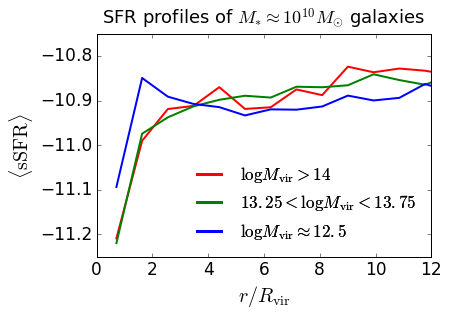

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rbins_normalized_midpoints, cluster_result, color='red', linewidth=2)
ax.plot(rbins_normalized_midpoints, group_result, color='green', linewidth=2)
ax.plot(rbins_normalized_midpoints, milky_way_result, color='blue', linewidth=2)

mean_sample_ssfr = np.mean(np.log10(sample['ssfr']))
# ax.plot(np.arange(100), np.zeros(100) + mean_sample_ssfr, ls='--', color='gray', linewidth=2)

xlabel = ax.set_xlabel(r'$r / R_{\rm vir}$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title(r'SFR profiles of $M_{\ast}\approx10^{10}M_{\odot}$ galaxies', 
                     fontsize=18, y=1.02) 

plt.xlabel(r'$r / R_{\rm vir}$', size=20)
plt.ylabel(r'$\langle{\rm sSFR}\rangle$', size=20)
plt.xticks(fontsize=17); plt.yticks(fontsize=17)
plt.xlim(xmin = 0., xmax=12)
plt.ylim(ymin = -11.25, ymax = -10.75)

red_line = mlines.Line2D([], [], c = 'red', linewidth=3, label = r'$\log M_{\rm vir} > 14$')
green_line = mlines.Line2D([], [], c = 'green', linewidth=3, label = r'$13.25 < \log M_{\rm vir} < 13.75$')
blue_line = mlines.Line2D([], [], c = 'blue', linewidth=3, label = r'$\log M_{\rm vir} \approx 12.5$')
first_legend = plt.legend(handles=[red_line, green_line, blue_line], frameon=False, loc='best', fontsize=17)
ax.add_artist(first_legend)

fig.savefig('FIGS/ssfr_normalized_profiles.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Absolute distance profiles

In [135]:
rbins = np.logspace(-1, np.log10(15), 20)
rbins_midpoints = (rbins[:-1] + rbins[1:])/2.

cluster_result = radial_profile_3d(cluster_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_absolute = rbins,
                           period=halocat.Lbox)

group_result = radial_profile_3d(group_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_absolute = rbins,
                           period=halocat.Lbox)

milky_way_result = radial_profile_3d(milky_way_pos, sample_pos, np.log10(sample['ssfr']),
                           rbins_absolute = rbins,
                           period=halocat.Lbox)

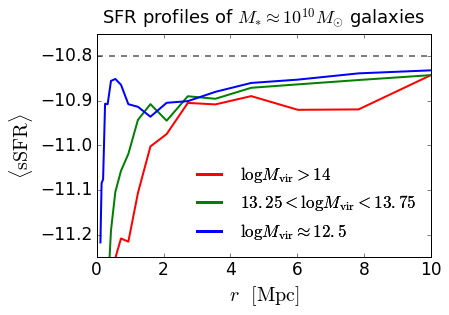

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(rbins_midpoints, cluster_result, color='red', linewidth=2)
ax.plot(rbins_midpoints, group_result, color='green', linewidth=2)
ax.plot(rbins_midpoints, milky_way_result, color='blue', linewidth=2)

mean_sample_ssfr = np.mean(np.log10(sample['ssfr']))
ax.plot(np.arange(100), np.zeros(100) + mean_sample_ssfr, ls='--', color='gray', linewidth=2)

xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title(r'SFR profiles of $M_{\ast}\approx10^{10}M_{\odot}$ galaxies', 
                     fontsize=18, y=1.02) 

plt.xticks(fontsize=17); plt.yticks(fontsize=17)
plt.xlim(xmin = 0., xmax=10)
plt.ylim(ymin = -11.25, ymax = -10.75)

red_line = mlines.Line2D([], [], c = 'red', linewidth=3, label = r'$\log M_{\rm vir} > 14$')
green_line = mlines.Line2D([], [], c = 'green', linewidth=3, label = r'$13.25 < \log M_{\rm vir} < 13.75$')
blue_line = mlines.Line2D([], [], c = 'blue', linewidth=3, label = r'$\log M_{\rm vir} \approx 12.5$')
first_legend = plt.legend(handles=[red_line, green_line, blue_line], frameon=False, loc='best', fontsize=17)
ax.add_artist(first_legend)

fig.savefig('FIGS/ssfr_profiles.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')